1. Setup

1.1 Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

1.2 Import TF and Deps

In [2]:
# General Modules
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import glob

# SSD Supporting Modules
sys.path.append('read_data/')
from SSD_VGG16 import L2Normalization, buildSSD_VGG16
from bbox_utils import generate_default_boxes, convert_to_box_form
from dataGenerator import DataGenerator
from getData import read_data, resize_images_and_labels, label_dimensions_normalized
from classification_loss import SSDLoss

2025-03-11 15:49:45.456209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 15:49:45.457499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 15:49:45.485201: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 15:49:45.486049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 15:49:45.993925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2. Collect and Organize Data

2.1 Generate The Anchor/Prior/Default Boxes

In [3]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]
aspect_ratios = [
    [1, 2, 0.5],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 3, 0.5, 0.333],
    [1, 2, 0.5],
    [1, 2, 0.5]
]
number_of_feature_maps = 6

prior_boxes = generate_default_boxes(feature_map_shapes, number_of_feature_maps, aspect_ratios)
boxes = convert_to_box_form(prior_boxes)

2.2 Retrieve Data for Training, Validation, and Testing

In [4]:
train_image_path = "data/train/images"
train_label_path = "data/train/labels"

val_image_path = "data/val/images"
val_label_path = "data/val/labels"

test_image_path = "data/test/images"
test_label_path = "data/test/labels"

In [5]:
list_train_IDs = glob.glob('data/train/labels/*.txt')

for idx, file_name in enumerate(list_train_IDs):
    list_train_IDs[idx] = file_name.replace(".txt", "").replace("data/train/labels/", "")

train_dg = DataGenerator(list_train_IDs, 
                   train_label_path,
                   train_image_path, 
                   prior_boxes,
                   boxes,
                   batch_size=8,
                   n_classes=1,
                   image_height=300,
                   image_width=300,
                   normalize=True,
                   shuffle=True,
                   image_extension=".jpg",
                   training=True)

In [6]:
list_val_IDs = glob.glob('data/val/labels/*.txt')

for idx, file_name in enumerate(list_val_IDs):
    list_val_IDs[idx] = file_name.replace(".txt", "").replace("data/val/labels/", "")

val_dg = DataGenerator(list_val_IDs, 
                   val_label_path,
                   val_image_path, 
                   prior_boxes,
                   boxes,
                   batch_size=8,
                   n_classes=1,
                   image_height=300,
                   image_width=300,
                   normalize=True,
                   shuffle=True,
                   image_extension=".jpg",
                   training=False)

In [7]:
list_test_IDs = glob.glob('data/test/labels/*.txt')

for idx, file_name in enumerate(list_test_IDs):
    list_test_IDs[idx] = file_name.replace(".txt", "").replace("data/test/labels/", "")

test_dg = DataGenerator(list_test_IDs, 
                   test_label_path,
                   test_image_path, 
                   prior_boxes,
                   boxes,
                   batch_size=8,
                   n_classes=1,
                   image_height=300,
                   image_width=300,
                   normalize=True,
                   shuffle=True,
                   image_extension=".jpg",
                   training=False)

3. Look At A Image In Training Set

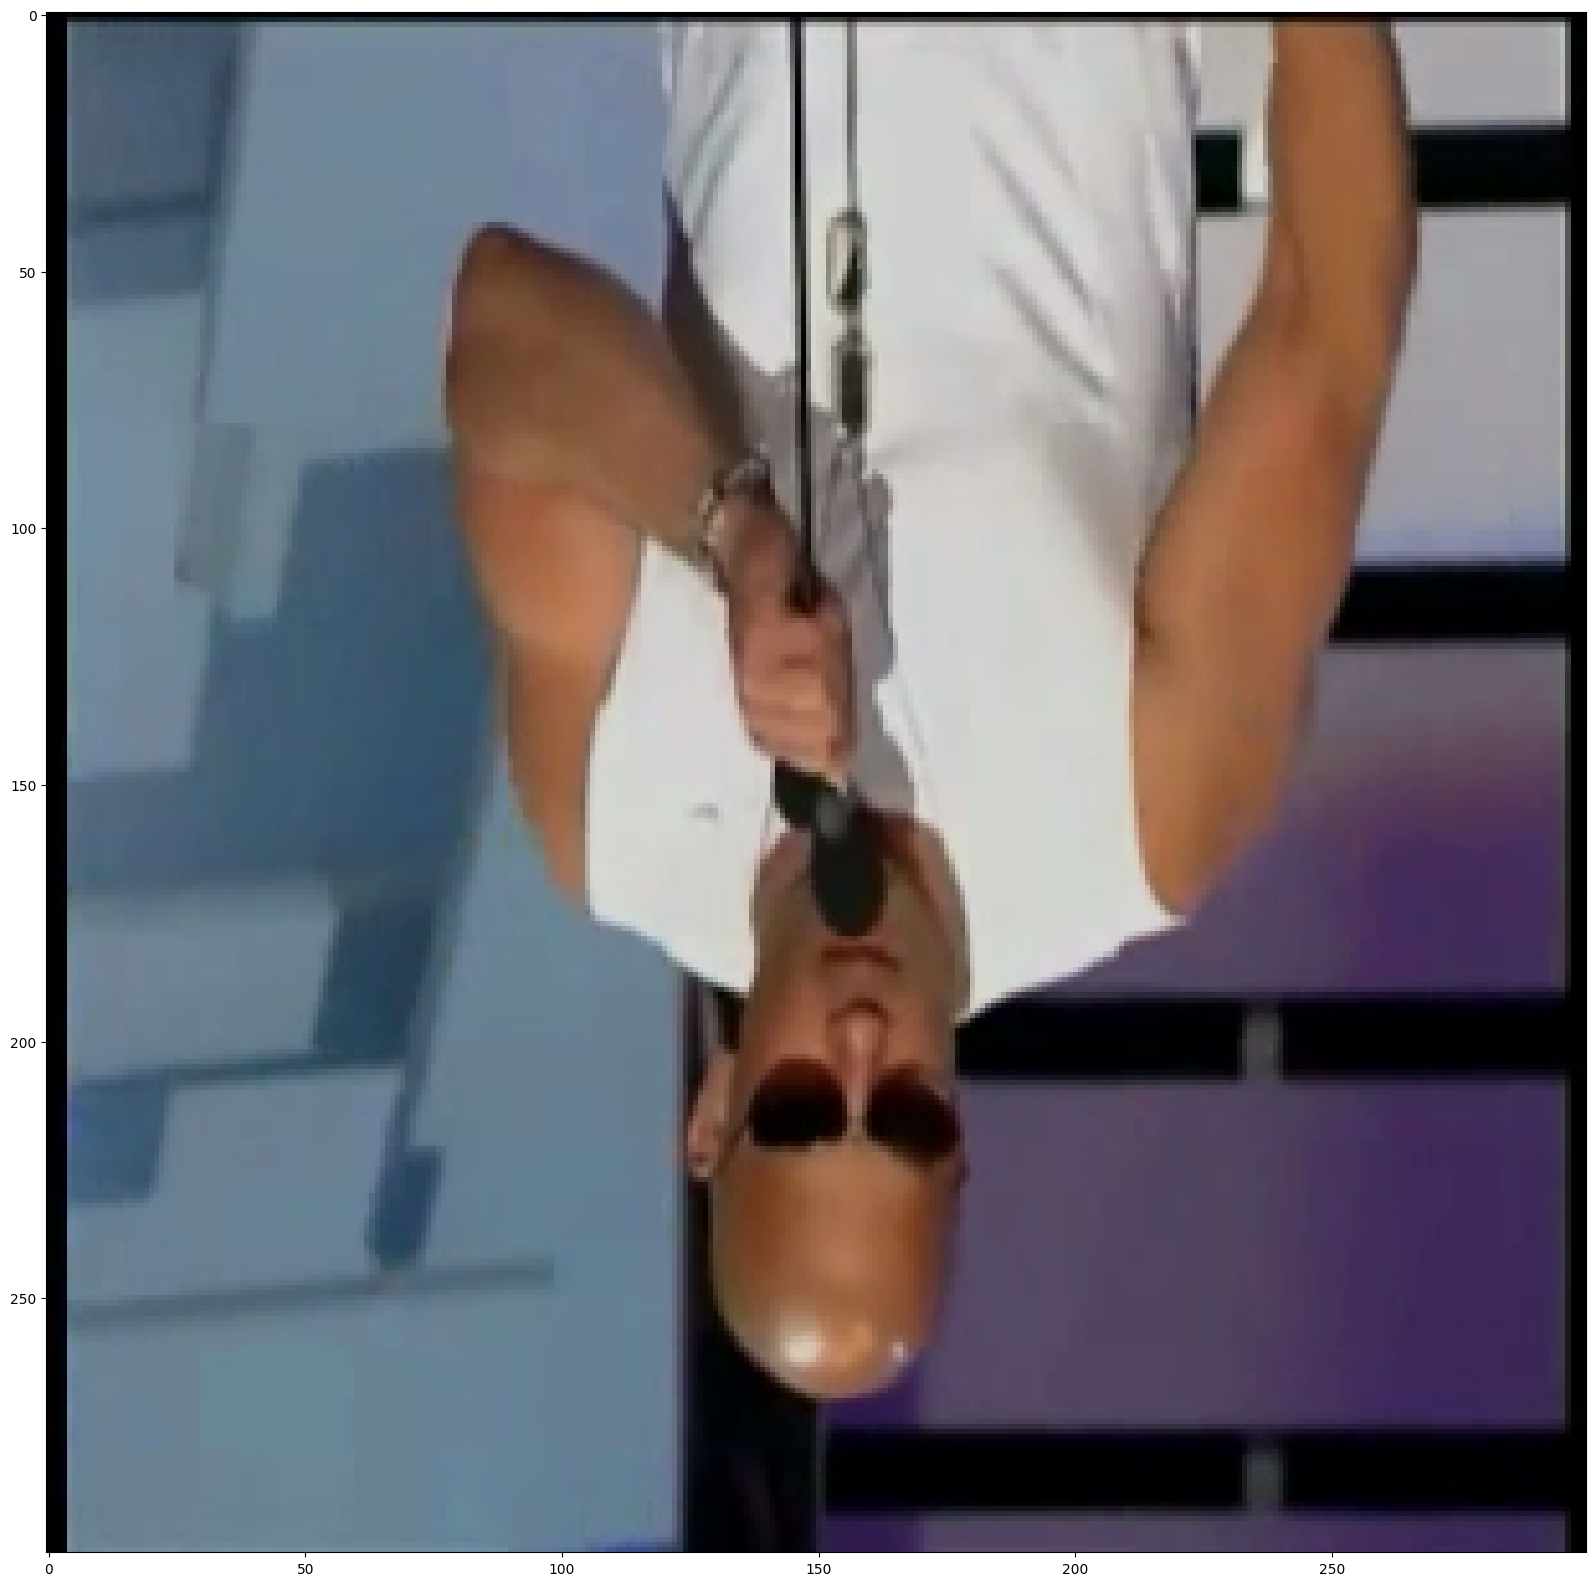

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(20,20))
sample_image = train_dg.__getitem__(0)[0][0,] # sample image
ax.imshow(sample_image)

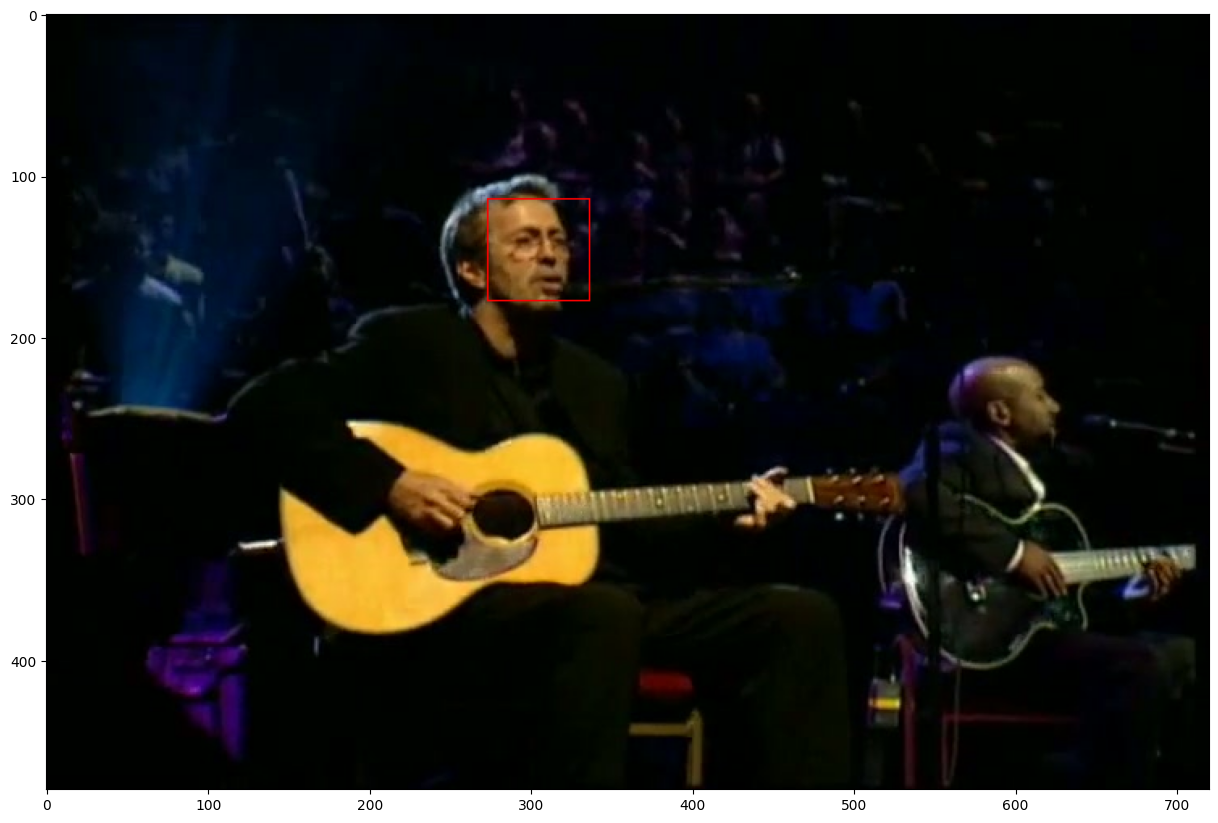

In [9]:
image, label = read_data("Eric_ClaptonQsZ2QsZ2.609", 
                         "data/train/images/", 
                         "data/train/labels/",
                         image_extension=".jpg")
plt.figure(figsize=(15, 15))

for _, x_min, y_min, x_max, y_max in label:
    image = cv2.rectangle(image, (x_min, y_min),
                          (x_max, y_max), (255,0,0), 1)

plt.imshow(image)

4. Instantiate The SSD Model and Test It (Without Training)

4.1 Build The Model

In [10]:
ssd = buildSSD_VGG16(2) # 1 class for faces, 1 for background

4.2 Define Model Output Gathering Function

In [11]:
def modelPreds(image_path, model):
    
    images = []

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))
    
    images.append(image)
    
    images = np.array(images) / 255.
    
    pred = model.predict(images)
    
    conf_loss = pred[1]
    
    g_cx_pred = pred[0][:,:,0] * prior_boxes[:,2] / 10 + prior_boxes[:,0]
    g_cy_pred =  pred[0][:,:,1] * prior_boxes[:,3] / 10 + prior_boxes[:,1]
    g_w_pred = tf.exp(pred[0][:,:,2] / 5) * prior_boxes[:,2]
    g_h_pred = tf.exp(pred[0][:,:,3] / 5) * prior_boxes[:,3]

    g_x_min = g_cx_pred - g_w_pred / 2
    g_y_min = g_cy_pred - g_h_pred / 2

    g_x_max = g_cx_pred + g_w_pred / 2
    g_y_max = g_cy_pred + g_h_pred / 2

    # tf.transpose(g_x_min, perm=(0,1))

    g_x_min_t = tf.transpose(tf.expand_dims(g_x_min, axis = 0), perm=(1,2,0))
    g_y_min_t = tf.transpose(tf.expand_dims(g_y_min, axis = 0), perm=(1,2,0))

    g_x_max_t = tf.transpose(tf.expand_dims(g_x_max, axis = 0), perm=(1,2,0))
    g_y_max_t = tf.transpose(tf.expand_dims(g_y_max, axis = 0), perm=(1,2,0))

    g_pred = tf.concat([g_x_min_t, g_y_min_t, g_x_max_t, g_y_max_t], axis = 2)
    
    image_number = 0
    
    selected_indices = tf.image.non_max_suppression(
                    g_pred[image_number], 
                    tf.reduce_max(conf_loss[image_number][:,1:], axis = 1), 
                    max_output_size=50,
                    iou_threshold=0.7,
                    score_threshold=0.5)

    selected_boxes = tf.gather(g_pred[image_number], selected_indices)
    labels_for_boxes = tf.argmax(tf.gather(conf_loss[image_number], selected_indices),axis = 1)
    confidence_score = tf.reduce_max(tf.gather(conf_loss[image_number], selected_indices), axis = 1)
    
    return selected_boxes, labels_for_boxes, confidence_score

4.3 Define Model Output Visualizing Function

In [12]:
def plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, labels, colors):
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    figsize=(10,10)
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    height = image.shape[0]
    width = image.shape[1]
    linewidth=1.5
    for i in range(confidence_score.shape[0]):

        score = confidence_score[i]
        xmin = int(selected_boxes[i, 0] * width)
        ymin = int(selected_boxes[i, 1] * height)
        xmax = int(selected_boxes[i, 2] * width)
        ymax = int(selected_boxes[i, 3] * height)
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False,
                             edgecolor=colors[0],
                             linewidth=linewidth)
        plt.gca().add_patch(rect)
        label_idx = labels_for_boxes[i].numpy()
        class_name = str(labels[label_idx - 1])
        plt.gca().text(xmin, ymin - 2,
                       '{:s} | {:.3f}'.format(class_name, score),
                       bbox=dict(facecolor=colors[0], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

4.4 Look At The Model's Guess w/ No Training

1/1 [==============================] - 0s 393ms/step


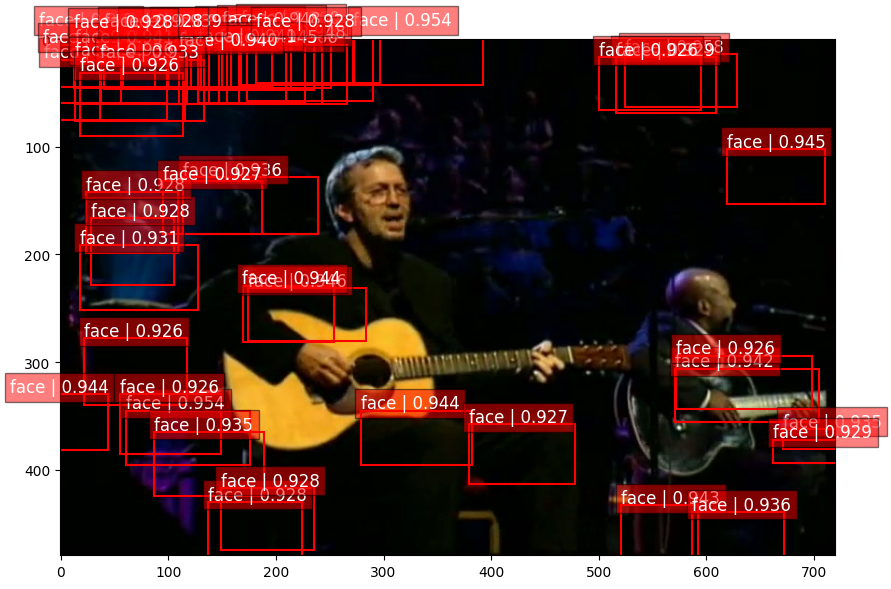

In [13]:
image_path = "data/train/images/Eric_ClaptonQsZ2QsZ2.600.jpg"

selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, ssd)

plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, ["face"], [(1,0,0)])

5. Train The Model

5.1 Setup Training Conditions

In [14]:
loss = SSDLoss()
ssd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=[loss.localization_loss, loss.confidence_loss])

5.2 Begin Training

In [15]:
hist = ssd.fit(train_dg, epochs=10)

Epoch 1/10
227/227 [==============================] - 1350s 6s/step - loss: 62.3007 - mbox_loc_loss: 29.9948 - mbox_conf_softmax_loss: 25.4345  
Epoch 2/10
227/227 [==============================] - 1388s 6s/step - loss: 36.9061 - mbox_loc_loss: 12.5187 - mbox_conf_softmax_loss: 18.7410
Epoch 3/10
227/227 [==============================] - 1392s 6s/step - loss: 32.3495 - mbox_loc_loss: 10.5820 - mbox_conf_softmax_loss: 16.6811
Epoch 4/10
227/227 [==============================] - 1394s 6s/step - loss: 29.9555 - mbox_loc_loss: 9.4043 - mbox_conf_softmax_loss: 15.8442
Epoch 5/10
227/227 [==============================] - 1405s 6s/step - loss: 28.3755 - mbox_loc_loss: 8.6569 - mbox_conf_softmax_loss: 15.3161
Epoch 6/10
227/227 [==============================] - 1399s 6s/step - loss: 27.1610 - mbox_loc_loss: 8.2235 - mbox_conf_softmax_loss: 14.7339
Epoch 7/10
227/227 [==============================] - 1401s 6s/step - loss: 24.9750 - mbox_loc_loss: 7.2745 - mbox_conf_softmax_loss: 13.6358
E

6. Save/Load Model (Optional)

6.1 Save The Model

In [16]:
# ssd.save("ssd.keras")

6.2 Load The Model

In [17]:
# from tensorflow.keras.models import load_model
# ssd = load_model("ssd.keras")

7. Evaluate Model Performance

7.1 Evaluate Model With A Training Image

1/1 [==============================] - 1s 527ms/step


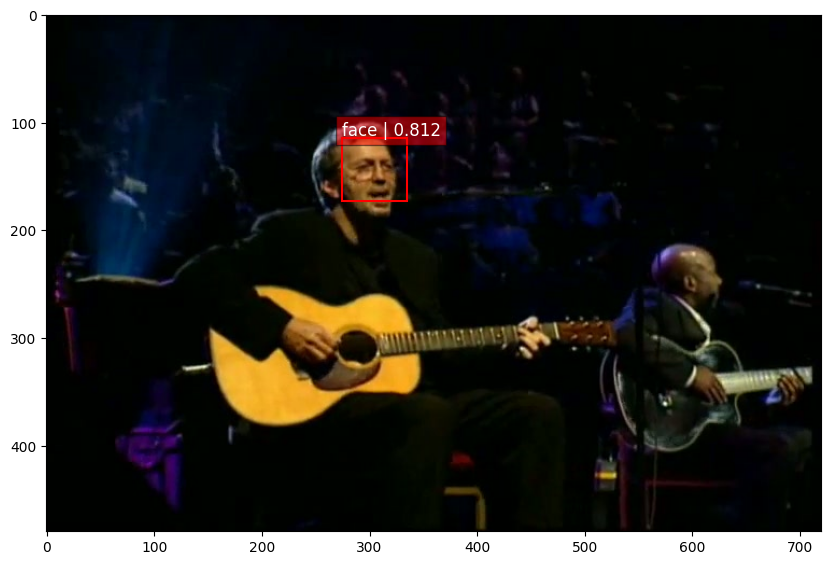

In [18]:
image_path = "data/train/images/Eric_ClaptonQsZ2QsZ2.600.jpg"

selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, ssd)

plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, ["face"], [(1,0,0)])

1/1 [==============================] - 0s 247ms/step


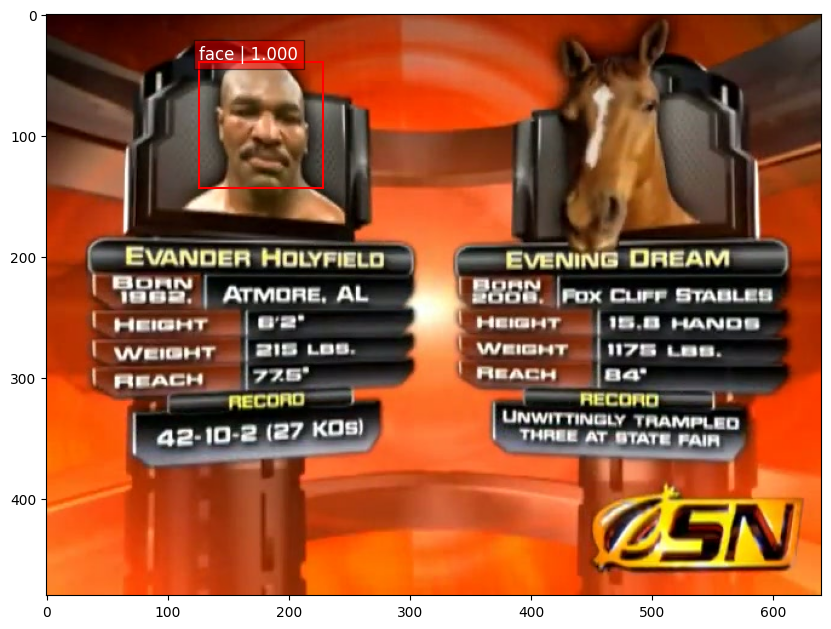

In [19]:
image_path = "data/train/images/Evander_HolyfieldQsZ0QsZ0.1564.jpg"

selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, ssd)

plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, ["face"], [(1,0,0)])

7.2 Evaluate Model With A Validation Image And Test Image

1/1 [==============================] - 0s 247ms/step


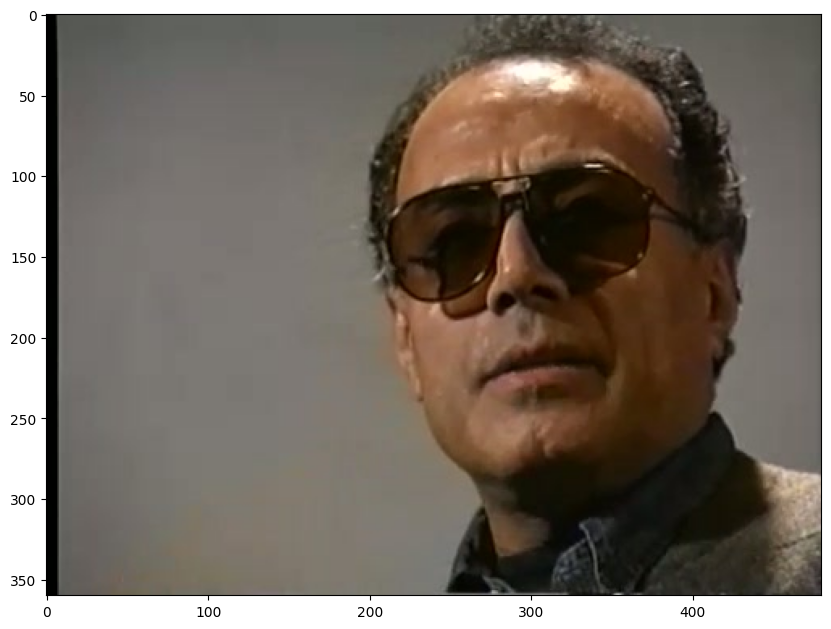

In [20]:
image_path = "data/test/images/Abbas_KiarostamiQsZ0QsZ0.1399.jpg"

selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, ssd)

plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, ["face"], [(1,0,0)])

1/1 [==============================] - 0s 245ms/step


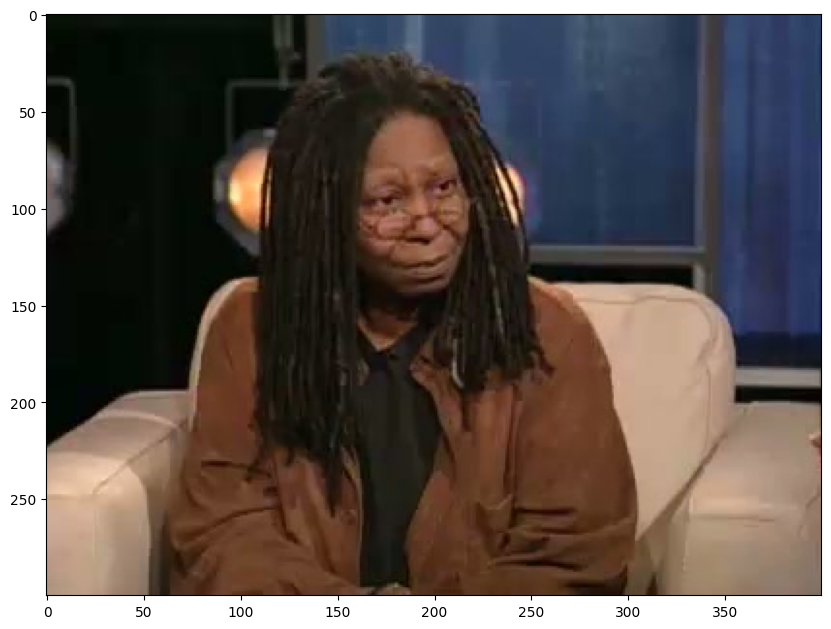

In [21]:
image_path = "data/val/images/Whoopi_GoldbergQsZ0QsZ0.177.jpg"

selected_boxes, labels_for_boxes, confidence_score = modelPreds(image_path, ssd)

plt_bboxes(image_path, selected_boxes, labels_for_boxes, confidence_score, ["face"], [(1,0,0)])